## First draft of HMC 

This is a first draft of the HMC algorithm. Be aware that this only implements the algorithm for a gaussian distribution of theta and momentum. The goal is to expand this to any possible distributions as well.

In [ ]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [10]:
std_momentum = 1
mean_momentum = 0

In [12]:
# Implementing a derivative function for the leapfrog algorithm
def derivative(func, x0, dx=1e-6):
    return (func(x0 + dx) - func(x0)) / dx

In [13]:
# Computing the potential energy
potential_energy = lambda x: -norm.logpdf(x, 0, 1)

Text(0.5, 0, '$\\theta$')

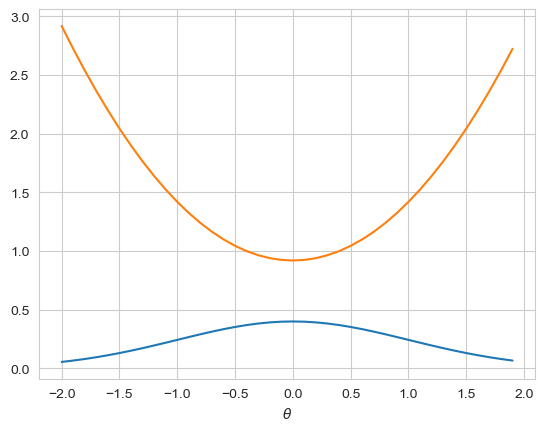

In [14]:
# First look into posterior distribution and neg log posterior
x = np.arange(-2, 2, 0.1)
plt.plot(x, norm.pdf(x, 0, 1))
plt.plot(x, potential_energy(x))
plt.xlabel(r'$\theta$')

The following leapfrom algorithm is implemented from this website: https://mc-stan.org/docs/reference-manual/mcmc.html

In [15]:
def leapfrog(momentum, theta, epsilon = 0.01, L = 20):
    m_star = momentum
    theta_star = theta
    for i in range(L):
        m_star = m_star - epsilon/2 * derivative(potential_energy, theta)
        theta_star = theta_star + epsilon * 1/std_momentum * m_star
        m_star = m_star - epsilon/2 * derivative(potential_energy, theta)
    return m_star, theta_star

<Axes: ylabel='Density'>

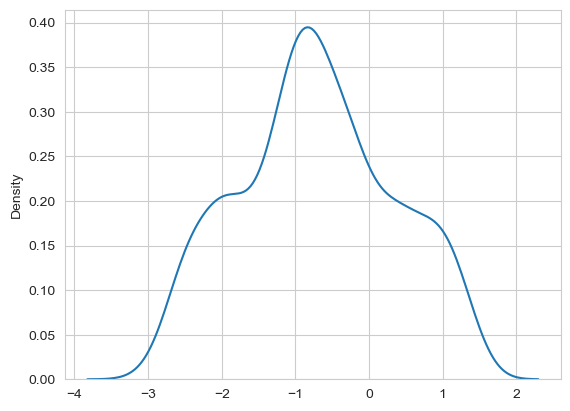

In [16]:
# Actual implementation of HMC
thetas = random.normal(size=1)
sample_momenta = []
m_star_list = []
for i in range(1000):
    momentum = random.normal(size=1, scale = std_momentum)
    
    sample_momenta.extend(momentum)
    m_star, theta_star = leapfrog(momentum, theta = thetas[-1], epsilon=0.001, L = 100)
    p_previous_theta = norm.pdf(thetas[-1])
    p_theta_star = norm.pdf(theta_star)
    p_previous_m = norm.pdf(momentum)
    p_m_star = norm.pdf(m_star)
    alpha = min(1, (p_theta_star*p_m_star)/(p_previous_theta*p_previous_m))


    if random.uniform() <= alpha:    #accept new value
        thetas = np.append(thetas, theta_star)
        m_star_list.extend(m_star)   

    else:    #keep old value
        thetas = np.append(thetas, thetas[-1])
        m_star_list.append(m_star[-1])
sns.kdeplot(thetas) # Marginal distribution of theta

<Axes: ylabel='Density'>

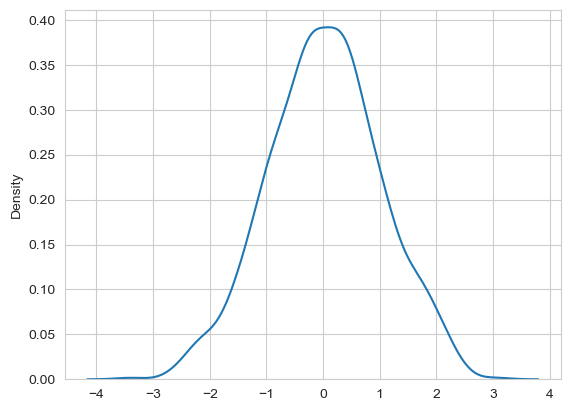

In [8]:
sns.kdeplot(sample_momenta) # Marginal distribution of momentum

Text(0, 0.5, 'Momentum $m$')

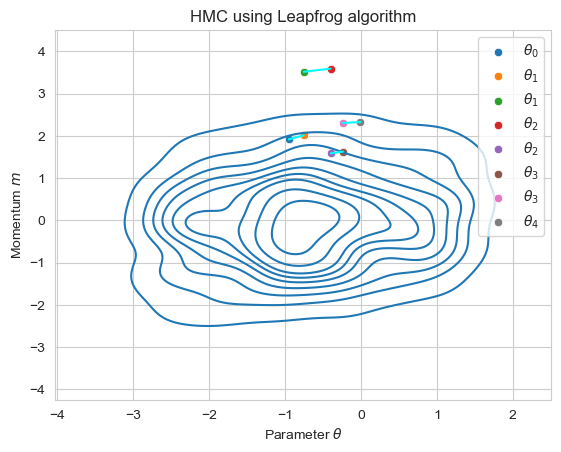

In [17]:
# Contour plot of combined theta and momentum, showing the first few thetas and momenta
sns.kdeplot(x = thetas[1:], y = sample_momenta)
for i in range(4):
    sns.lineplot(x = thetas[i:i+2], y = [sample_momenta[i], m_star_list[i]], color = 'cyan')  
    sns.scatterplot(x = [thetas[i]], y = [sample_momenta[i]], label = fr'$\theta_{i}$')
    sns.scatterplot(x = [thetas[i+1]], y = [m_star_list[i]], label = fr'$\theta_{i+1}$')


plt.title('HMC using Leapfrog algorithm')
plt.xlabel(r'Parameter $\theta$')  

plt.ylabel('Momentum $m$')